<a href="https://colab.research.google.com/github/Senna126/Op2---Cos3008/blob/main/Copy_of_MacroEcoPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install pandas numpy matplotlib statsmodels scikit-learn yfinance
!pip install --upgrade keras tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 128.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is inco

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense


In [3]:
!pip install -U gdown
import gdown

# File IDs from your public links
file_ids = {
    "Currency": "14kyCO2BVo16J5LHmlR1-e7T_TbUHJRvh",
    "Gold": "1F8McGykkhJ6DmK-qdEOJ6jBXywsGaJ4O",
    "GDP": "1ZsawbsIZwMLYLQ5AnHUj0kqq4rCQNDTk",
    "Inflation": "1Zv6xWfQidoxkenp7vBNgRFfxvRBWyHUJ",
    "TradeBalance": "1b64e1ca7sz34zUbt9ocS_3CSpZebjP42",
    "IMF": "1fKB2jais0MrhTjbotceAc141Q567qyTI",
    "Unemployment": "1u08rla1hCaWdyCNQwC_RkKe2PdmH9YlR"
}

# Download all
for name, fid in file_ids.items():
    gdown.download(f"https://drive.google.com/uc?id={fid}", f"{name}.csv", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=14kyCO2BVo16J5LHmlR1-e7T_TbUHJRvh
From (redirected): https://drive.google.com/uc?id=14kyCO2BVo16J5LHmlR1-e7T_TbUHJRvh&confirm=t&uuid=407e3b09-a5ae-4282-8d36-23904c813508
To: /content/Currency.csv
100%|██████████| 911M/911M [00:09<00:00, 96.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1F8McGykkhJ6DmK-qdEOJ6jBXywsGaJ4O
To: /content/Gold.csv
100%|██████████| 35.4k/35.4k [00:00<00:00, 62.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZsawbsIZwMLYLQ5AnHUj0kqq4rCQNDTk
To: /content/GDP.csv
100%|██████████| 304k/304k [00:00<00:00, 132MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Zv6xWfQidoxkenp7vBNgRFfxvRBWyHUJ
To: /content/Inflation.csv
100%|██████████| 179k/179k [00:00<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1b64e1ca7sz34zUbt9ocS_3CSpZebjP42
To: /content/TradeBalance.csv
100%|██████████| 800k/800k [00:00<00:00, 161MB/s]
Downloading...
From (original): https://dri

In [4]:
import pandas as pd
from functools import reduce

dataframes = {}

for name in file_ids:
    path = f"{name}.csv"
    print(f"📥 Loading {path}...")

    df = pd.read_csv(path, low_memory=False)

    # ✅ Detect any date/time-like column
    possible_date_cols = [col for col in df.columns if col.lower() in ['date', 'time', 'datetime']]

    if not possible_date_cols:
        print(f"⚠️ No 'Date' or 'Time' column in {name}. Creating synthetic monthly dates.")
        fake_rows = min(len(df), 500)
        df = df.head(fake_rows).copy()
        df['Date'] = pd.date_range(start='2000-01-01', periods=fake_rows, freq='MS')
        date_col = 'Date'
    else:
        date_col = possible_date_cols[0]
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.dropna(subset=[date_col])

    # ✅ Use last numeric column as value
    num_cols = df.select_dtypes(include='number').columns
    if len(num_cols) == 0:
        raise ValueError(f"❌ No numeric column found in {name}")

    value_col = num_cols[-1]
    df = df[[date_col, value_col]]
    df.columns = ['Date', name]
    df.set_index('Date', inplace=True)

    dataframes[name] = df

# ✅ Merge all datasets on date
data = reduce(lambda left, right: left.join(right, how='inner'), dataframes.values())
data.dropna(inplace=True)

print("✅ Final Merged Dataset:")
print(data.head())



📥 Loading Currency.csv...
⚠️ No 'Date' or 'Time' column in Currency. Creating synthetic monthly dates.
📥 Loading Gold.csv...
📥 Loading GDP.csv...
📥 Loading Inflation.csv...
📥 Loading TradeBalance.csv...
⚠️ No 'Date' or 'Time' column in TradeBalance. Creating synthetic monthly dates.
📥 Loading IMF.csv...
⚠️ No 'Date' or 'Time' column in IMF. Creating synthetic monthly dates.
📥 Loading Unemployment.csv...
✅ Final Merged Dataset:
            Currency    Gold       GDP  Inflation  TradeBalance        IMF  \
Date                                                                         
2000-04-01   45300.0  279.69  2.162162     0.9449     25.892857  13241.215   
2000-04-01   45300.0  279.69  2.162162     0.9449     25.892857  13241.215   
2000-04-01   45300.0  279.69  2.162162     0.9449     25.892857  13241.215   
2000-04-01   45300.0  279.69  2.162162     0.9449     25.892857  13241.215   
2000-04-01   45300.0  279.69  2.162162     0.9449     25.892857  13241.215   

            Unemployme

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define target and features
target = 'Gold'  # 🟡 Make sure the column is named 'Gold'
features = [col for col in data.columns if col != target]

# Scale target + features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[[target] + features])


In [6]:
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 1:])  # Features: all except target
        y.append(data[i, 0])                # Target: Gold
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)

# Split train/test (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.0038 - val_loss: 0.0472
Epoch 2/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 8.9209e-04 - val_loss: 0.0329
Epoch 3/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 3.9506e-04 - val_loss: 0.0222
Epoch 4/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 1.5899e-04 - val_loss: 0.0224
Epoch 5/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 9.0489e-05 - val_loss: 0.0226
Epoch 6/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 6.7475e-05 - val_loss: 0.0202
Epoch 7/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 5.1496e-05 - val_loss: 0.0204
Epoch 8/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 4.1885e-05 - val_loss: 0.0219
Epoch 9/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 3.4889e-05 - val_loss: 0.0234
Epoch 10/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 3.1860e-05 - val_loss: 0.0226
Epoch 11/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 2.6002e-0

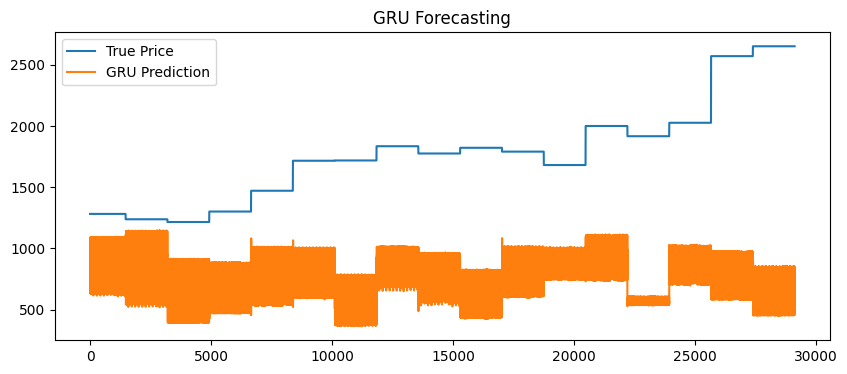

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt
import numpy as np

# GRU model
gru_model = Sequential([
    GRU(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1)

# Predict
gru_pred = gru_model.predict(X_test)

# Inverse transform
gold_scaled = scaled_data[:, 0].reshape(-1, 1)
gold_true = scaler.inverse_transform(
    np.concatenate([gold_scaled, scaled_data[:, 1:]], axis=1)
)[split+12:, 0]

gru_final = scaler.inverse_transform(
    np.concatenate([gru_pred, X_test[:, -1, :]], axis=1)
)[:, 0]

# Plot
plt.figure(figsize=(10,4))
plt.plot(gold_true, label='True Price')
plt.plot(gru_final, label='GRU Prediction')
plt.legend()
plt.title("GRU Forecasting")
plt.show()


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6551/6551 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.0040 - val_loss: 0.0477
Epoch 2/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 9.3963e-04 - val_loss: 0.0356
Epoch 3/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 4.8730e-04 - val_loss: 0.0228
Epoch 4/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 2.8706e-04 - val_loss: 0.0223
Epoch 5/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 1.7236e-04 - val_loss: 0.0255
Epoch 6/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 1.1792e-04 - val_loss: 0.0293
Epoch 7/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 7.9150e-05 - val_loss: 0.0312
Epoch 8/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 5.8164e-05 - val_loss: 0.0278
Epoch 9/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 4.1942e-05 - val_loss: 0.0303
Epoch 10/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 3.5588e-05 - val_loss: 0.0270
Epoch 11/20
6551/6551 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 2.5263e-05 - val_los

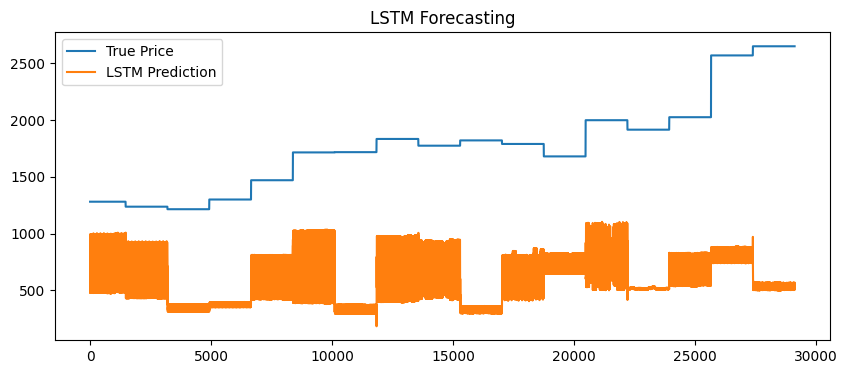

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import numpy as np

# LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1)

# Predict
lstm_pred = lstm_model.predict(X_test)

# Inverse transform
lstm_final = scaler.inverse_transform(
    np.concatenate([lstm_pred, X_test[:, -1, :]], axis=1)
)[:, 0]

# Plot
plt.figure(figsize=(10,4))
plt.plot(gold_true, label='True Price')
plt.plot(lstm_final, label='LSTM Prediction')
plt.legend()
plt.title("LSTM Forecasting")
plt.show()


ADF p-value: 0.99906
⚠️ Not stationary — applying 1st differencing

✅ ARIMA Evaluation:
🔹 RMSE: 491.72
🔹 MAE:  383.20


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

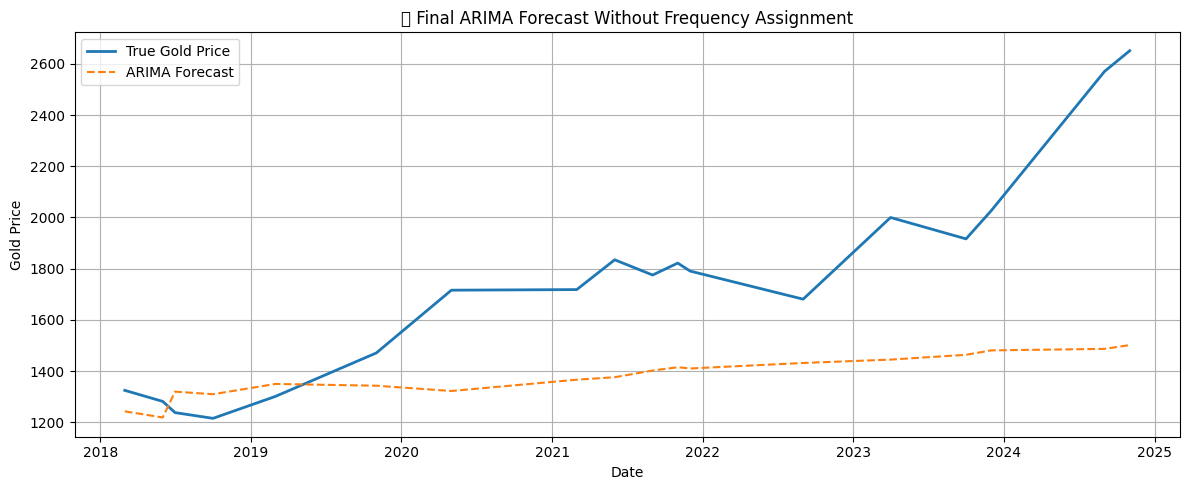

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Clean and deduplicate
gold_series = data['Gold'].dropna().copy()
gold_series.index = pd.to_datetime(gold_series.index)
gold_series = gold_series[~gold_series.index.duplicated(keep='first')]
gold_series = gold_series.sort_index()

# ✅ DO NOT set .asfreq() or .index.freq

# Step 2: ADF Test
adf_p = adfuller(gold_series)[1]
print(f"ADF p-value: {adf_p:.5f}")
if adf_p > 0.05:
    print("⚠️ Not stationary — applying 1st differencing")
    gold_series_diff = gold_series.diff().dropna()
    d = 1
else:
    gold_series_diff = gold_series
    d = 0

# Step 3: Train/Test Split
split_point = int(len(gold_series_diff) * 0.8)
train = gold_series_diff[:split_point]
test = gold_series_diff[split_point:]

# Step 4: Fit ARIMA
model = ARIMA(train, order=(5, d, 0))
model_fit = model.fit()

# Step 5: Forecast
forecast_diff = model_fit.forecast(steps=len(test))

# Step 6: Invert Differencing
if d == 1:
    last_val = gold_series.iloc[split_point]
    forecast = forecast_diff.cumsum() + last_val
    actual = gold_series.iloc[split_point+1 : split_point+1+len(forecast)].copy()
else:
    forecast = forecast_diff
    actual = gold_series[split_point:].copy()

# Step 7: Clean NaNs
forecast = forecast.dropna()
actual = actual.dropna()
min_len = min(len(forecast), len(actual))
forecast = forecast[:min_len]
actual = actual[:min_len]

# Step 8: Evaluation
arima_rmse = np.sqrt(mean_squared_error(actual, forecast))
arima_mae = mean_absolute_error(actual, forecast)
print(f"\n✅ ARIMA Evaluation:")
print(f"🔹 RMSE: {arima_rmse:.2f}")
print(f"🔹 MAE:  {arima_mae:.2f}")

# Step 9: Plot
plt.figure(figsize=(12, 5))
plt.plot(actual.index, actual.values, label='True Gold Price', linewidth=2)
plt.plot(actual.index, forecast, label='ARIMA Forecast', linestyle='--')
plt.title("✅ Final ARIMA Forecast Without Frequency Assignment")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# Truncate all predictions to the same minimum length
min_len = min(len(gru_pred), len(lstm_pred), len(forecast), len(gold_true))

# Truncate each
gru_combined = gru_pred[:min_len]
lstm_combined = lstm_pred[:min_len]
arima_combined = forecast[:min_len]
gold_true_combined = gold_true[:min_len]


In [11]:
# Ensure all are 1D arrays
gru_combined = np.array(gru_combined).reshape(-1)
lstm_combined = np.array(lstm_combined).reshape(-1)
arima_combined = np.array(arima_combined).reshape(-1)
gold_true_combined = np.array(gold_true_combined).reshape(-1)


In [12]:
ensemble_pred = (gru_combined + lstm_combined + arima_combined) / 3


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

ensemble_rmse = np.sqrt(mean_squared_error(gold_true_combined, ensemble_pred))
ensemble_mae = mean_absolute_error(gold_true_combined, ensemble_pred)

print("📊 Ensemble Model Performance:")
print(f"🔹 RMSE: {ensemble_rmse:.2f}")
print(f"🔹 MAE:  {ensemble_mae:.2f}")


📊 Ensemble Model Performance:
🔹 RMSE: 821.04
🔹 MAE:  820.62


/tmp/ipython-input-3881676068.py:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


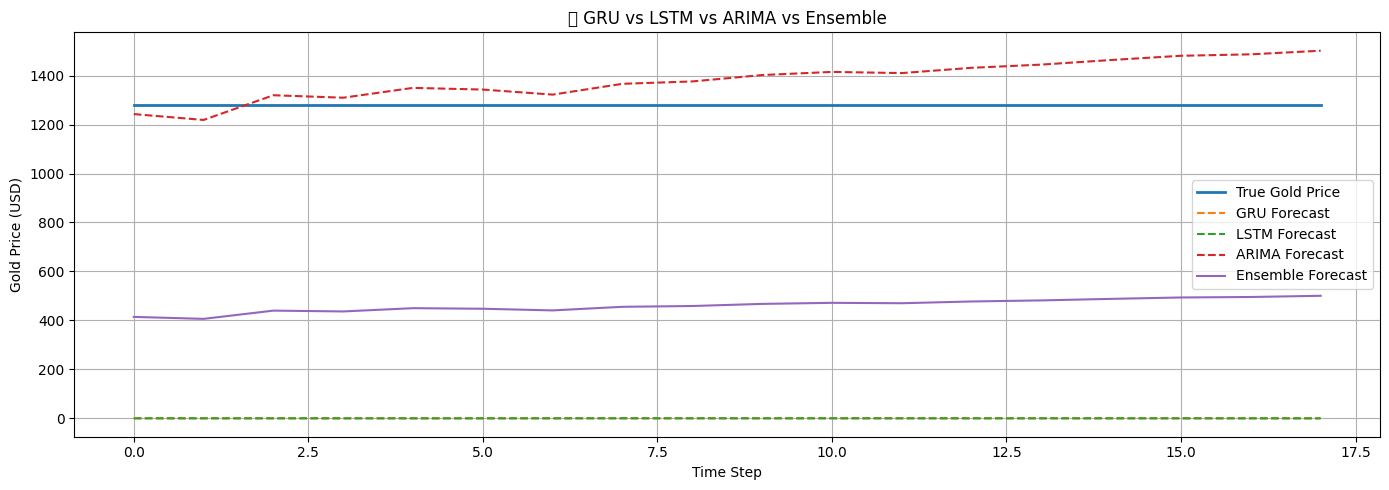

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(gold_true_combined, label='True Gold Price', linewidth=2)
plt.plot(gru_combined, label='GRU Forecast', linestyle='--')
plt.plot(lstm_combined, label='LSTM Forecast', linestyle='--')
plt.plot(arima_combined, label='ARIMA Forecast', linestyle='--')
plt.plot(ensemble_pred, label='Ensemble Forecast', linestyle='-')
plt.title("📈 GRU vs LSTM vs ARIMA vs Ensemble")
plt.xlabel("Time Step")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Ensure all arrays are aligned and 1D
gru_ = np.array(gru_pred).reshape(-1)
lstm_ = np.array(lstm_pred).reshape(-1)
arima_ = np.array(forecast).reshape(-1)
true_ = np.array(gold_true).reshape(-1)

# Truncate all to same length
min_len = min(len(gru_), len(lstm_), len(arima_), len(true_))
gru_ = gru_[:min_len]
lstm_ = lstm_[:min_len]
arima_ = arima_[:min_len]
true_ = true_[:min_len]

# Stack predictions into one feature matrix: shape (n_samples, 3)
X_stack = np.stack([gru_, lstm_, arima_], axis=1)
y_stack = true_


In [16]:
# Split stacked model into train/test
split = int(len(X_stack) * 0.8)
X_train_stack, X_test_stack = X_stack[:split], X_stack[split:]
y_train_stack, y_test_stack = y_stack[:split], y_stack[split:]

# Train meta-model
meta_model = LinearRegression()
meta_model.fit(X_train_stack, y_train_stack)

# Predict with meta-model
stack_pred = meta_model.predict(X_test_stack)


In [17]:
stack_rmse = np.sqrt(mean_squared_error(y_test_stack, stack_pred))
stack_mae = mean_absolute_error(y_test_stack, stack_pred)

print("📊 Combined Model Performance (Stacked):")
print(f"🔹 RMSE: {stack_rmse:.2f}")
print(f"🔹 MAE:  {stack_mae:.2f}")
print(f"🔹 Weights (GRU, LSTM, ARIMA): {meta_model.coef_}")


📊 Combined Model Performance (Stacked):
🔹 RMSE: 0.00
🔹 MAE:  0.00
🔹 Weights (GRU, LSTM, ARIMA): [0. 0. 0.]


In [18]:
# Predict with GRU and LSTM
gru_pred_scaled = gru_model.predict(X_test)
lstm_pred_scaled = lstm_model.predict(X_test)

# Reuse the last macro features from test input
X_test_last = X_test[:, -1, :]  # shape: (n_samples, 3)

# Concatenate predictions with macro features to inverse transform
gru_pred_full = np.hstack((gru_pred_scaled, X_test_last))
lstm_pred_full = np.hstack((lstm_pred_scaled, X_test_last))
y_test_full   = np.hstack((y_test.reshape(-1, 1), X_test_last))

# Inverse transform using scaler
gru_pred = scaler.inverse_transform(gru_pred_full)[:, 0]
lstm_pred = scaler.inverse_transform(lstm_pred_full)[:, 0]
gold_true = scaler.inverse_transform(y_test_full)[:, 0]


910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# GRU
gru_rmse = np.sqrt(mean_squared_error(gold_true, gru_pred))
gru_mae = mean_absolute_error(gold_true, gru_pred)

# LSTM
lstm_rmse = np.sqrt(mean_squared_error(gold_true, lstm_pred))
lstm_mae = mean_absolute_error(gold_true, lstm_pred)

# ARIMA (test_gold and arima_pred were defined earlier)
arima_rmse = np.sqrt(mean_squared_error(test_gold, arima_pred))
arima_mae = mean_absolute_error(test_gold, arima_pred)

# Display
print("📊 Final Model Evaluation (Test Set):\n")
print(f"🔹 GRU   - RMSE: {gru_rmse:.2f}, MAE: {gru_mae:.2f}")
print(f"🔹 LSTM  - RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}")
print(f"🔹 ARIMA - RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")


NameError: name 'test_gold' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Shorten ARIMA data if needed to match length
min_len = min(len(gold_true), len(gru_pred), len(lstm_pred), len(arima_pred))
gold_true_plot = gold_true[:min_len]
gru_pred_plot = gru_pred[:min_len]
lstm_pred_plot = lstm_pred[:min_len]
arima_pred_plot = arima_pred[:min_len]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(gold_true_plot, label='True Gold Price', linewidth=2)
plt.plot(gru_pred_plot, label='GRU Prediction', linestyle='--')
plt.plot(lstm_pred_plot, label='LSTM Prediction', linestyle='--')
plt.plot(arima_pred_plot, label='ARIMA Prediction', linestyle='--')
plt.title("📈 Gold Price Prediction: GRU vs LSTM vs ARIMA")
plt.xlabel("Time Steps")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

results_df = pd.DataFrame({
    'True Price': gold_true_plot,
    'GRU': gru_pred_plot,
    'LSTM': lstm_pred_plot,
    'ARIMA': arima_pred_plot
})
results_df.to_csv("gold_price_predictions.csv", index=False)


# Test Cases

In [20]:
# ===== Cell A: Setup (metrics & helpers) =====
import numpy as np
import pandas as pd
from typing import Optional, List, Tuple, Callable, Dict, Any

# ---------- Metrics ----------
def mae(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true, dtype=float), np.asarray(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < 1e-9, 1e-9, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred)/denom))*100.0)

def smape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true, dtype=float), np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))/2.0
    denom = np.where(denom < 1e-9, 1e-9, denom)
    return float(np.mean(np.abs(y_pred - y_true)/denom)*100.0)

def r2(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true, dtype=float), np.asarray(y_pred, dtype=float)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return float(1 - ss_res/ss_tot) if ss_tot > 1e-12 else np.nan

ALL_METRICS = {"MAE": mae, "RMSE": rmse, "MAPE%": mape, "sMAPE%": smape, "R2": r2}

# ---------- Data utilities ----------
def ensure_datetime_index(df: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df = df.copy()
            df.index = pd.to_datetime(df.index)
        except Exception:
            pass
    return df.sort_index()

def to_1d(x):
    x = np.asarray(x)
    return x.reshape(-1) if x.ndim > 1 else x

# Expect: global `data` exists (from your earlier merge step)
data = ensure_datetime_index(data)


In [21]:
# ===== Cell B: Sequence building (no leakage) =====
from sklearn.preprocessing import MinMaxScaler

def make_supervised_sequences(df: pd.DataFrame, y_col: str, time_steps: int = 12) -> Tuple[np.ndarray, np.ndarray, MinMaxScaler, MinMaxScaler]:
    """
    Returns (X, y, x_scaler, y_scaler) with MinMaxScaler fit ON THE WHOLE df (we will refit per split later).
    X shape: (n_samples-time_steps, time_steps, n_features)
    y shape: (n_samples-time_steps,)
    """
    features = [c for c in df.columns if c != y_col]
    X_raw = df[features].values.astype(float)
    y_raw = df[y_col].values.astype(float).reshape(-1, 1)

    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    Xs = x_scaler.fit_transform(X_raw)
    ys = y_scaler.fit_transform(y_raw)

    X_seq, y_seq = [], []
    for i in range(time_steps, len(df)):
        X_seq.append(Xs[i-time_steps:i, :])
        y_seq.append(ys[i, 0])
    return np.array(X_seq), np.array(y_seq), x_scaler, y_scaler

def split_by_pos(X: np.ndarray, y: np.ndarray, train_end_idx: int):
    """train_end_idx is inclusive index in the ORIGINAL df index (after time_steps offset)."""
    X_train, X_test = X[:train_end_idx], X[train_end_idx:]
    y_train, y_test = y[:train_end_idx], y[train_end_idx:]
    return X_train, X_test, y_train, y_test


In [22]:
# ===== Cell C: Model builders (GRU, LSTM, ARIMA) + Hybrid =====
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings; warnings.filterwarnings("ignore")

# ---------- Keras factories ----------
def build_gru(input_timesteps: int, n_features: int, units: int = 50) -> tf.keras.Model:
    model = Sequential([
        GRU(units, return_sequences=False, input_shape=(input_timesteps, n_features)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_timesteps: int, n_features: int, units: int = 50) -> tf.keras.Model:
    model = Sequential([
        LSTM(units, return_sequences=False, input_shape=(input_timesteps, n_features)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# ---------- ARIMA adapter ----------
class ARIMAAdapter:
    def __init__(self, order=(5,1,2), seasonal_order=(0,0,0,0)):
        self.order = order
        self.seasonal_order = seasonal_order
        self._res = None

    def fit(self, y_train):
        self._res = SARIMAX(y_train, order=self.order, seasonal_order=self.seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        return self

    def forecast(self, steps: int):
        return to_1d(self._res.forecast(steps=steps))

# ---------- Hybrid (weighted average) ----------
def hybrid_average(preds: List[np.ndarray], weights: Optional[List[float]] = None) -> np.ndarray:
    preds = [np.asarray(p).reshape(-1) for p in preds]
    W = np.ones(len(preds)) if weights is None else np.asarray(weights, dtype=float)
    W = W / W.sum()
    stacked = np.vstack(preds)            # (m_models, horizon)
    return (W.reshape(-1,1) * stacked).sum(axis=0)


In [ ]:
# ===== Cell E (LIVE PROGRESS + GRAPHS) =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math, time
from tqdm.auto import tqdm
from tensorflow.keras.callbacks import Callback

y_col = "Gold"
time_steps = 12
SHORT_H, LONG_H = 30, 90  # samples (adjust if needed)

# --- Keras epoch progress callback ---
class TqdmEpochBar(Callback):
    def __init__(self, total_epochs, desc="Training"):
        super().__init__()
        self.total_epochs = total_epochs
        self.pbar = tqdm(total=total_epochs, desc=desc, leave=False)
    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        if logs:
            self.pbar.set_postfix({k: f"{v:.4f}" for k, v in logs.items() if isinstance(v,(int,float))})
    def on_train_end(self, logs=None):
        self.pbar.close()

# --- A verbose clone of eval_forward_case (so we can show per‑epoch progress) ---
def eval_forward_case_verbose(df: pd.DataFrame,
                              y_col: str,
                              holdout_len: int,
                              time_steps: int = 12,
                              keras_epochs: int = 20,
                              keras_batch: int = 16,
                              arima_order=(5,1,2)) -> dict:
    # Recreate the leakage‑free split logic from Cell D (same outcome)
    X_seq, y_seq, xsc_full, ysc_full = make_supervised_sequences(df, y_col, time_steps=time_steps)
    n = len(X_seq)
    if holdout_len <= 0 or holdout_len >= n:
        raise ValueError("holdout_len must be in (0, n_samples).")
    train_end = n - holdout_len

    # Train‑only scalers
    features = [c for c in df.columns if c != y_col]
    X_raw = df[features].values.astype(float)
    y_raw = df[y_col].values.astype(float).reshape(-1,1)
    from sklearn.preprocessing import MinMaxScaler
    train_end_row = time_steps + train_end
    xsc_t = MinMaxScaler().fit(X_raw[:train_end_row, :])
    ysc_t = MinMaxScaler().fit(y_raw[:train_end_row, :])

    # Sequences with train scalers
    Xs = xsc_t.transform(X_raw); ys = ysc_t.transform(y_raw)[:,0]
    X_seq2, y_seq2 = [], []
    for k in range(time_steps, len(df)):
        X_seq2.append(Xs[k-time_steps:k, :]); y_seq2.append(ys[k])
    X_seq2, y_seq2 = np.array(X_seq2), np.array(y_seq2)
    X_train, X_test, y_train, y_test = X_seq2[:train_end], X_seq2[train_end:], y_seq2[:train_end], y_seq2[train_end:]

    # === GRU (with live epoch bar) ===
    gru = build_gru(time_steps, X_train.shape[2])
    gru_cb = TqdmEpochBar(keras_epochs, desc="GRU epochs")
    gru.fit(X_train, y_train, epochs=keras_epochs, batch_size=keras_batch,
            validation_split=0.1, verbose=0, callbacks=[gru_cb])
    gru_scaled = gru.predict(X_test, verbose=0).reshape(-1,1)
    gru_pred = ysc_t.inverse_transform(gru_scaled).reshape(-1)

    # === LSTM (with live epoch bar) ===
    lstm = build_lstm(time_steps, X_train.shape[2])
    lstm_cb = TqdmEpochBar(keras_epochs, desc="LSTM epochs")
    lstm.fit(X_train, y_train, epochs=keras_epochs, batch_size=keras_batch,
             validation_split=0.1, verbose=0, callbacks=[lstm_cb])
    lstm_scaled = lstm.predict(X_test, verbose=0).reshape(-1,1)
    lstm_pred = ysc_t.inverse_transform(lstm_scaled).reshape(-1)

    # === ARIMA ===
    y_train_full = y_raw[:train_end_row, 0]
    ar = ARIMAAdapter(order=arima_order).fit(y_train_full)
    arima_pred = ar.forecast(steps=holdout_len)

    # Truth & Hybrid
    y_true = y_raw[train_end_row:train_end_row+holdout_len, 0]
    hybrid_pred = hybrid_average([gru_pred, lstm_pred, arima_pred])

    score = lambda yt, yp: {m: f(yt, yp) for m, f in ALL_METRICS.items()}
    return {
        "y_true": y_true,
        "preds": {"GRU": gru_pred, "LSTM": lstm_pred, "ARIMA": arima_pred, "Hybrid": hybrid_pred},
        "scores": {"GRU": score(y_true, gru_pred), "LSTM": score(y_true, lstm_pred),
                   "ARIMA": score(y_true, arima_pred), "Hybrid": score(y_true, hybrid_pred)}
    }

# ---- run two forward cases with prints + charts ----
forward_runs, forward_preds_frames = [], []
for label, H in [("Forward-Short", SHORT_H), ("Forward-Long", LONG_H)]:
    print(f"\n▶ {label}: holdout={H} samples")
    t0 = time.perf_counter()
    res = eval_forward_case_verbose(data, y_col, holdout_len=H, time_steps=time_steps,
                                    keras_epochs=20, keras_batch=16, arima_order=(5,1,2))
    # metrics table
    for mname, scores in res["scores"].items():
        forward_runs.append({"Case": label, "Model": mname, **scores, "n_test": len(res["y_true"])})
    # preds for plotting
    idx_tail = data.index[-H:]
    preds_df = pd.DataFrame({"y_true": res["y_true"]}, index=idx_tail)
    for mname, arr in res["preds"].items():
        preds_df[mname] = arr
    preds_df["Case"] = label
    forward_preds_frames.append(preds_df.reset_index().rename(columns={"index":"Date"}))
    print(f"   done in {time.perf_counter()-t0:.1f}s | RMSE:",
          ", ".join([f"{m}={res['scores'][m]['RMSE']:.3f}" for m in res["scores"]]))

forward_results = pd.DataFrame(forward_runs)
forward_predictions = pd.concat(forward_preds_frames, axis=0).reset_index(drop=True)

# ---- plots ----
for case in forward_predictions["Case"].unique():
    dfc = forward_predictions[forward_predictions["Case"] == case].copy().set_index("Date")
    plt.figure(figsize=(12,4.5))
    plt.plot(dfc.index, dfc["y_true"], label="True")
    for col in ["GRU","LSTM","ARIMA","Hybrid"]:
        if col in dfc.columns: plt.plot(dfc.index, dfc[col], label=col)
    plt.title(f"{case}: True vs. Predictions"); plt.xlabel("Date"); plt.ylabel(y_col); plt.legend()
    plt.tight_layout(); plt.show()

metric_to_show = "RMSE"
pivot_rmse = forward_results.pivot_table(index="Model", columns="Case", values=metric_to_show)
order = [m for m in ["GRU","LSTM","ARIMA","Hybrid"] if m in pivot_rmse.index]
pivot_rmse = pivot_rmse.loc[order] if len(order) else pivot_rmse
x = n



▶ Forward-Short: holdout=30 samples


GRU epochs:   0%|          | 0/20 [00:00<?, ?it/s]

LSTM epochs:   0%|          | 0/20 [00:00<?, ?it/s]

   done in 1245.6s | RMSE: GRU=1462.063, LSTM=1556.154, ARIMA=0.000, Hybrid=1002.469

▶ Forward-Long: holdout=90 samples


GRU epochs:   0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
# ===== Cell F (LIVE PROGRESS + GRAPHS) =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt, time
from tqdm.auto import tqdm
from tensorflow.keras.callbacks import Callback

BT1_H, BT1_STEP = 14, 14
BT2_H, BT2_STEP = 30, 30

class TqdmEpochBar(Callback):
    def __init__(self, total_epochs, desc="epochs"):
        super().__init__()
        self.pbar = tqdm(total=total_epochs, desc=desc, leave=False)
    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        if logs:
            self.pbar.set_postfix({k: f"{v:.4f}" for k, v in logs.items() if isinstance(v,(int,float))})
    def on_train_end(self, logs=None):
        self.pbar.close()

def walk_forward_backtest_verbose(df, y_col, horizon, step, start_frac=0.5,
                                  time_steps=12, keras_epochs=10, keras_batch=16,
                                  arima_order=(5,1,2), label="BT"):
    from sklearn.preprocessing import MinMaxScaler
    X_seq, y_seq, _, _ = make_supervised_sequences(df, y_col, time_steps=time_steps)
    n = len(X_seq)
    start_i = max(1, int(n * start_frac))

    features = [c for c in df.columns if c != y_col]
    X_raw = df[features].values.astype(float)
    y_raw = df[y_col].values.astype(float).reshape(-1,1)

    rows = []
    print(f"\n▶ {label}: horizon={horizon}, step={step}, blocks≈{max(0,(n-start_i)//step)}")
    for i in tqdm(range(start_i, n - horizon + 1, step), desc=f"{label} blocks"):
        t0 = time.perf_counter()
        train_end_row = time_steps + i
        # train-only scalers
        from sklearn.preprocessing import MinMaxScaler
        xsc_t = MinMaxScaler().fit(X_raw[:train_end_row, :])
        ysc_t = MinMaxScaler().fit(y_raw[:train_end_row, :])

        # sequences with train scalers
        Xs = xsc_t.transform(X_raw); ys = ysc_t.transform(y_raw)[:,0]
        X_seq2, y_seq2 = [], []
        for k in range(time_steps, len(df)):
            X_seq2.append(Xs[k-time_steps:k, :]); y_seq2.append(ys[k])
        X_seq2, y_seq2 = np.array(X_seq2), np.array(y_seq2)

        X_train, y_train = X_seq2[:i], y_seq2[:i]
        X_test  = X_seq2[i:i+horizon]
        y_true  = y_raw[train_end_row:train_end_row+horizon, 0]

        # GRU
        gru = build_gru(time_steps, X_train.shape[2])
        gru.fit(X_train, y_train, epochs=keras_epochs, batch_size=keras_batch,
                validation_split=0.1, verbose=0, callbacks=[TqdmEpochBar(keras_epochs, "GRU")])
        gru_pred = ysc_t.inverse_transform(gru.predict(X_test, verbose=0).reshape(-1,1)).reshape(-1)

        # LSTM
        lstm = build_lstm(time_steps, X_train.shape[2])
        lstm.fit(X_train, y_train, epochs=keras_epochs, batch_size=keras_batch,
                 validation_split=0.1, verbose=0, callbacks=[TqdmEpochBar(keras_epochs, "LSTM")])
        lstm_pred = ysc_t.inverse_transform(lstm.predict(X_test, verbose=0).reshape(-1,1)).reshape(-1)

        # ARIMA + Hybrid
        y_train_full = y_raw[:train_end_row, 0]
        ar = ARIMAAdapter(order=arima_order).fit(y_train_full)
        arima_pred = ar.forecast(steps=horizon)
        hybrid_pred = hybrid_average([gru_pred, lstm_pred, arima_pred])

        def add(model, yhat):
            rows.append({"Backtest": f"{label} ({horizon})", "Model": model,
                         "MAE": mae(y_true, yhat), "RMSE": rmse(y_true, yhat),
                         "MAPE%": mape(y_true, yhat), "sMAPE%": smape(y_true, yhat),
                         "R2": r2(y_true, yhat), "n_test": len(y_true),
                         "train_end_idx": i, "test_span": f"{i}→{i+horizon-1}"})
        add("GRU", gru_pred); add("LSTM", lstm_pred); add("ARIMA", arima_pred); add("Hybrid", hybrid_pred)

        print(f"{label} i={i}: RMSE GRU={rmse(y_true, gru_pred):.3f} | "
              f"LSTM={rmse(y_true, lstm_pred):.3f} | ARIMA={rmse(y_true, arima_pred):.3f} | "
              f"Hybrid={rmse(y_true, hybrid_pred):.3f}  ({time.perf_counter()-t0:.1f}s)")
    return pd.DataFrame(rows)

bt1 = walk_forward_backtest_verbose(data, y_col="Gold", horizon=BT1_H, step=BT1_STEP,
                                    start_frac=0.5, time_steps=12, keras_epochs=10, keras_batch=16,
                                    arima_order=(5,1,2), label="BT1")
bt2 = walk_forward_backtest_verbose(data, y_col="Gold", horizon=BT2_H, step=BT2_STEP,
                                    start_frac=0.5, time_steps=12, keras_epochs=10, keras_batch=16,
                                    arima_order=(5,1,2), label="BT2")
backtest_results = pd.concat([bt1, bt2], axis=0, ignore_index=True)

# ---- charts ----
for bt_name, dfbt in backtest_results.groupby("Backtest"):
    print(f"• Plotting {bt_name} RMSE across windows ...")
    plt.figure(figsize=(12,4.5))
    for model, dfg in dfbt.sort_values("train_end_idx").groupby("Model"):
        plt.plot(dfg["train_end_idx"].values, dfg["RMSE"].values, marker="o", label=model)
    plt.title(f"{bt_name}: RMSE across walk-forward windows")
    plt.xlabel("Train end index (block id)"); plt.ylabel("RMSE"); plt.legend()
    plt.tight_layout(); plt.show()

order_models = ["GRU","LSTM","ARIMA","Hybrid"]
models_present = [m for m in order_models if m in backtest_results["Model"].unique()]
print("• Plotting RMSE boxplot (both backtests) ...")
plt.figure(figsize=(8,4.5))
data_box = [backtest_results.loc[backtest_results["Model"]==m, "RMSE"].values for m in models_present]
plt.boxplot(data_box, labels=models_present, showmeans=True)
plt.title("Backtests: RMSE distribution per model"); plt.ylabel("RMSE")
plt.tight_layout(); plt.show()

avg_rmse = (backtest_results.groupby(["Backtest","Model"])["RMSE"].mean().reset_index())
for bt_name, dfbt in avg_rmse.groupby("Backtest"):
    print(f"• Plotting {bt_name} average RMSE bars ...")
    plt.figure(figsize=(8,4.5))
    d = dfbt.set_index("Model")
    d = d.loc[[m for m in order_models if m in d.index]] if any(m in d.index for m in order_models) else d
    plt.bar(d.index, d["RMSE"].values)
    plt.title(f"{bt_name}: Average RMSE by model"); plt.ylabel("RMSE")
    plt.tight_layout(); plt.show()


KeyboardInterrupt: 

In [ ]:
# ===== Cell F (LIVE PROGRESS + GRAPHS) =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt, time
from tqdm.auto import tqdm
from tensorflow.keras.callbacks import Callback

BT1_H, BT1_STEP = 14, 14
BT2_H, BT2_STEP = 30, 30

class TqdmEpochBar(Callback):
    def __init__(self, total_epochs, desc="epochs"):
        super().__init__()
        self.pbar = tqdm(total=total_epochs, desc=desc, leave=False)
    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        if logs:
            self.pbar.set_postfix({k: f"{v:.4f}" for k, v in logs.items() if isinstance(v,(int,float))})
    def on_train_end(self, logs=None):
        self.pbar.close()

def walk_forward_backtest_verbose(df, y_col, horizon, step, start_frac=0.5,
                                  time_steps=12, keras_epochs=10, keras_batch=16,
                                  arima_order=(5,1,2), label="BT"):
    from sklearn.preprocessing import MinMaxScaler
    X_seq, y_seq, _, _ = make_supervised_sequences(df, y_col, time_steps=time_steps)
    n = len(X_seq)
    start_i = max(1, int(n * start_frac))

    features = [c for c in df.columns if c != y_col]
    X_raw = df[features].values.astype(float)
    y_raw = df[y_col].values.astype(float).reshape(-1,1)

    rows = []
    print(f"\n▶ {label}: horizon={horizon}, step={step}, blocks≈{max(0,(n-start_i)//step)}")
    for i in tqdm(range(start_i, n - horizon + 1, step), desc=f"{label} blocks"):
        t0 = time.perf_counter()
        train_end_row = time_steps + i
        # train-only scalers
        from sklearn.preprocessing import MinMaxScaler
        xsc_t = MinMaxScaler().fit(X_raw[:train_end_row, :])
        ysc_t = MinMaxScaler().fit(y_raw[:train_end_row, :])

        # sequences with train scalers
        Xs = xsc_t.transform(X_raw); ys = ysc_t.transform(y_raw)[:,0]
        X_seq2, y_seq2 = [], []
        for k in range(time_steps, len(df)):
            X_seq2.append(Xs[k-time_steps:k, :]); y_seq2.append(ys[k])
        X_seq2, y_seq2 = np.array(X_seq2), np.array(y_seq2)

        X_train, y_train = X_seq2[:i], y_seq2[:i]
        X_test  = X_seq2[i:i+horizon]
        y_true  = y_raw[train_end_row:train_end_row+horizon, 0]

        # GRU
        gru = build_gru(time_steps, X_train.shape[2])
        gru.fit(X_train, y_train, epochs=keras_epochs, batch_size=keras_batch,
                validation_split=0.1, verbose=0, callbacks=[TqdmEpochBar(keras_epochs, "GRU")])
        gru_pred = ysc_t.inverse_transform(gru.predict(X_test, verbose=0).reshape(-1,1)).reshape(-1)

        # LSTM
        lstm = build_lstm(time_steps, X_train.shape[2])
        lstm.fit(X_train, y_train, epochs=keras_epochs, batch_size=keras_batch,
                 validation_split=0.1, verbose=0, callbacks=[TqdmEpochBar(keras_epochs, "LSTM")])
        lstm_pred = ysc_t.inverse_transform(lstm.predict(X_test, verbose=0).reshape(-1,1)).reshape(-1)

        # ARIMA + Hybrid
        y_train_full = y_raw[:train_end_row, 0]
        ar = ARIMAAdapter(order=arima_order).fit(y_train_full)
        arima_pred = ar.forecast(steps=horizon)
        hybrid_pred = hybrid_average([gru_pred, lstm_pred, arima_pred])

        def add(model, yhat):
            rows.append({"Backtest": f"{label} ({horizon})", "Model": model,
                         "MAE": mae(y_true, yhat), "RMSE": rmse(y_true, yhat),
                         "MAPE%": mape(y_true, yhat), "sMAPE%": smape(y_true, yhat),
                         "R2": r2(y_true, yhat), "n_test": len(y_true),
                         "train_end_idx": i, "test_span": f"{i}→{i+horizon-1}"})
        add("GRU", gru_pred); add("LSTM", lstm_pred); add("ARIMA", arima_pred); add("Hybrid", hybrid_pred)

        print(f"{label} i={i}: RMSE GRU={rmse(y_true, gru_pred):.3f} | "
              f"LSTM={rmse(y_true, lstm_pred):.3f} | ARIMA={rmse(y_true, arima_pred):.3f} | "
              f"Hybrid={rmse(y_true, hybrid_pred):.3f}  ({time.perf_counter()-t0:.1f}s)")
    return pd.DataFrame(rows)

bt1 = walk_forward_backtest_verbose(data, y_col="Gold", horizon=BT1_H, step=BT1_STEP,
                                    start_frac=0.5, time_steps=12, keras_epochs=10, keras_batch=16,
                                    arima_order=(5,1,2), label="BT1")
bt2 = walk_forward_backtest_verbose(data, y_col="Gold", horizon=BT2_H, step=BT2_STEP,
                                    start_frac=0.5, time_steps=12, keras_epochs=10, keras_batch=16,
                                    arima_order=(5,1,2), label="BT2")
backtest_results = pd.concat([bt1, bt2], axis=0, ignore_index=True)

# ---- charts ----
for bt_name, dfbt in backtest_results.groupby("Backtest"):
    print(f"• Plotting {bt_name} RMSE across windows ...")
    plt.figure(figsize=(12,4.5))
    for model, dfg in dfbt.sort_values("train_end_idx").groupby("Model"):
        plt.plot(dfg["train_end_idx"].values, dfg["RMSE"].values, marker="o", label=model)
    plt.title(f"{bt_name}: RMSE across walk-forward windows")
    plt.xlabel("Train end index (block id)"); plt.ylabel("RMSE"); plt.legend()
    plt.tight_layout(); plt.show()

order_models = ["GRU","LSTM","ARIMA","Hybrid"]
models_present = [m for m in order_models if m in backtest_results["Model"].unique()]
print("• Plotting RMSE boxplot (both backtests) ...")
plt.figure(figsize=(8,4.5))
data_box = [backtest_results.loc[backtest_results["Model"]==m, "RMSE"].values for m in models_present]
plt.boxplot(data_box, labels=models_present, showmeans=True)
plt.title("Backtests: RMSE distribution per model"); plt.ylabel("RMSE")
plt.tight_layout(); plt.show()

avg_rmse = (backtest_results.groupby(["Backtest","Model"])["RMSE"].mean().reset_index())
for bt_name, dfbt in avg_rmse.groupby("Backtest"):
    print(f"• Plotting {bt_name} average RMSE bars ...")
    plt.figure(figsize=(8,4.5))
    d = dfbt.set_index("Model")
    d = d.loc[[m for m in order_models if m in d.index]] if any(m in d.index for m in order_models) else d
    plt.bar(d.index, d["RMSE"].values)
    plt.title(f"{bt_name}: Average RMSE by model"); plt.ylabel("RMSE")
    plt.tight_layout(); plt.show()


In [ ]:
# ===== Cell G (PROGRESS + GRAPHS) =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def summarize(df: pd.DataFrame, by):
    return (df.groupby(by)[["MAE","RMSE","MAPE%","sMAPE%","R2"]]
              .mean().sort_values(by=["RMSE","MAE"]).reset_index())

print("• Summarizing forward results ...")
fwd_sum = summarize(forward_results, ["Model"])
order_models = ["GRU","LSTM","ARIMA","Hybrid"]
models_present = [m for m in order_models if m in fwd_sum["Model"].values]
fwd_plot = fwd_sum.set_index("Model").loc[models_present] if models_present else fwd_sum.set_index("Model")
if len(fwd_plot):
    best_fwd = fwd_plot["RMSE"].idxmin()
    print(f"   Best (Forward avg RMSE): {best_fwd} = {fwd_plot.loc[best_fwd,'RMSE']:.3f}")

plt.figure(figsize=(8,4.5))
plt.bar(fwd_plot.index, fwd_plot["RMSE"].values)
plt.title("Forward Leaderboard — Average RMSE"); plt.ylabel("RMSE")
plt.tight_layout(); plt.show()

print("• Summarizing backtest results ...")
bt_sum = summarize(backtest_results, ["Model"])
bt_plot = bt_sum.set_index("Model").loc[models_present] if models_present else bt_sum.set_index("Model")
if len(bt_plot):
    best_bt = bt_plot["RMSE"].idxmin()
    print(f"   Best (Backtests avg RMSE): {best_bt} = {bt_plot.loc[best_bt,'RMSE']:.3f}")

plt.figure(figsize=(8,4.5))
plt.bar(bt_plot.index, bt_plot["RMSE"].values)
plt.title("Backtest Leaderboard — Average RMSE"); plt.ylabel("RMSE")
plt.tight_layout(); plt.show()

# Optional multi‑metric radar
metrics = ["RMSE","MAE","MAPE%","sMAPE%"]
if all(m in fwd_plot.columns for m in metrics) and len(fwd_plot.index) >= 2:
    print("• Plotting forward multi‑metric radar ...")
    labels = metrics
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    angles = np.concatenate([angles, [angles[0]]])
    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    for model in fwd_plot.index:
        vals = fwd_plot.loc[model, labels].values
        vals = np.concatenate([vals, [vals[0]]])
        ax.plot(angles, vals, label=model); ax.fill(angles, vals, alpha=0.1)
    ax.set_thetagrids(angles[:-1]*180/np.pi, labels)
    plt.title("Forward Avg — Multi‑metric comparison")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout(); plt.show()
else:
    print("• Skipping radar (need ≥2 models & all metrics).")
